In [40]:
import numpy as np
from astropy.io import fits
from DS_WCS_projections import custom_wcs, draw_circles
from DS_data_transformation import *
import DS_Coma_Cluster_param as cc_prm
from tqdm.notebook import tqdm
import healpy as hp
from astropy.coordinates import SkyCoord
from astropy import units as u
import os
import pandas as pd

In [2]:
wcs = custom_wcs(cc_prm.ra_center, cc_prm.dec_center)
alpha = 0.5
matr_rot = np.array([[np.cos(alpha), -np.sin(alpha)],
                    [np.sin(alpha), np.cos(alpha)]])
wcs.wcs.cd = np.dot(wcs.wcs.cd, matr_rot)

/home/rt2122/L/git/data-segmentation-2/modules/DS_WCS_projections.py:39: RuntimeWarning: cdelt will be ignored since cd is present
  w1.wcs.cdelt = w.wcs.cdelt[:2]


In [22]:
def interopalte_planck(wcs, fits_name, radius, inclusive=True):
    from astropy.coordinates import SkyCoord
    from astropy import units as u
    import healpy as hp
    
    data = None
    with fits.open(fits_name) as hdul:
        data = np.array(hdul[1].data['I_STOKES'])
    planck_nside = 2048
    
    pic = np.zeros(wcs.array_shape)
    for x in tqdm(range(pic.shape[0])):
        ra, dec = wcs.all_pix2world(np.full(pic.shape[1], x), 
                                    np.arange(pic.shape[1]), 0)
        sc = SkyCoord(ra=ra*u.degree, dec=dec*u.degree, frame='icrs')
        theta = sc.galactic.l.degree
        phi = sc.galactic.b.degree
        vec = hp.ang2vec(theta=theta, phi=phi, lonlat=True)
        for y in range(pic.shape[1]):
            disc = hp.query_disc(planck_nside, vec[y], np.radians(radius), nest=True, 
                             inclusive=inclusive)
            pic[x, y] = np.mean(data[disc])
    return pic

In [23]:
pic = interopalte_planck(wcs, 
    '/home/rt2122/Data/Planck/HFI_SkyMap_100_2048_R3.01_full.fits', 
                        0.014)

In [36]:
sc_cen = SkyCoord(ra=cc_prm.ra_center*u.degree, dec=cc_prm.dec_center*u.degree, 
                 frame='icrs')
vec = hp.ang2vec(theta=sc_cen.galactic.l.degree, phi=sc_cen.galactic.b.degree, 
                 lonlat=True)
len(hp.query_disc(2048, vec, np.radians(0.02), True))

8

In [24]:
pic -= pic.min()
pic /= pic.max()

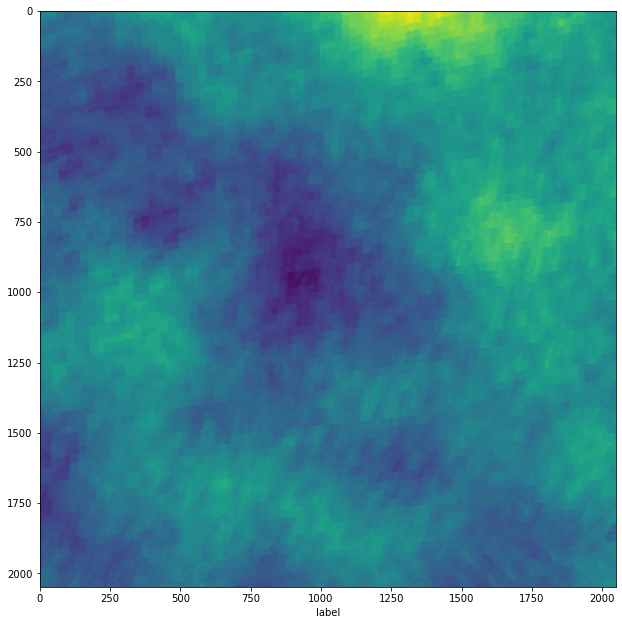

In [25]:
show_pic(pic)

In [27]:
dirname = '/home/rt2122/Data/Planck/'
files = sorted(next(os.walk(dirname))[-1])
files

['HFI_SkyMap_100_2048_R3.01_full.fits',
 'HFI_SkyMap_143_2048_R3.01_full.fits',
 'HFI_SkyMap_217_2048_R3.01_full.fits',
 'HFI_SkyMap_353_2048_R3.01_full.fits',
 'HFI_SkyMap_545_2048_R3.01_full.fits',
 'HFI_SkyMap_857_2048_R3.01_full.fits']

In [37]:
pic = []
for file in files:
    new_pic = interopalte_planck(wcs, os.path.join(dirname, file), 0.02)
    pic.append(new_pic.reshape(list(new_pic.shape) + [1]))

In [29]:
pic = np.dstack(pic)

In [33]:
pic_n = np.copy(pic)
for i in range(6):
    pic_n[:,:,i] -= pic_n[:,:,i].min()
    pic_n[:,:,i] /= pic_n[:,:,i].max()

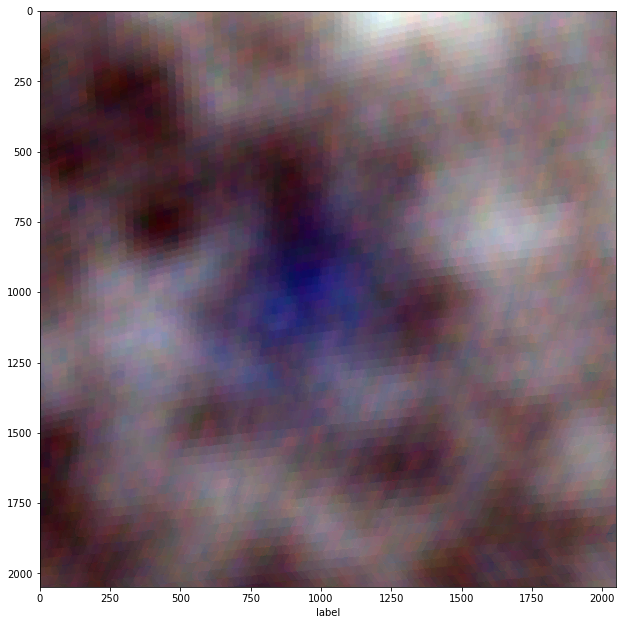

In [34]:
show_pic(pic_n[:,:,:3])

In [46]:
df = pd.read_csv('/home/rt2122/Data/coma_sweep/south/circle_2degree_filtered.csv')
df = n_max_flux_df(df, 100, ['FLUX_G', 'FLUX_R', 'FLUX_Z'])
pixels = wcs.all_world2pix(np.array(df['RA']), np.array(df['DEC']), 0)
pixels = np.array(pixels, dtype=np.int32).T
exmpl = draw_circles(pixels, np.array(df['FLUX_G'] + df['FLUX_R'] + df['FLUX_Z']), 
                    (2048, 2048, 1), 0.02)
exmpl1 = draw_circles(pixels, np.array(df['FLUX_G'] + df['FLUX_R'] + df['FLUX_Z']), 
                    (2048, 2048, 1), 0.015)
exmpl -= exmpl1

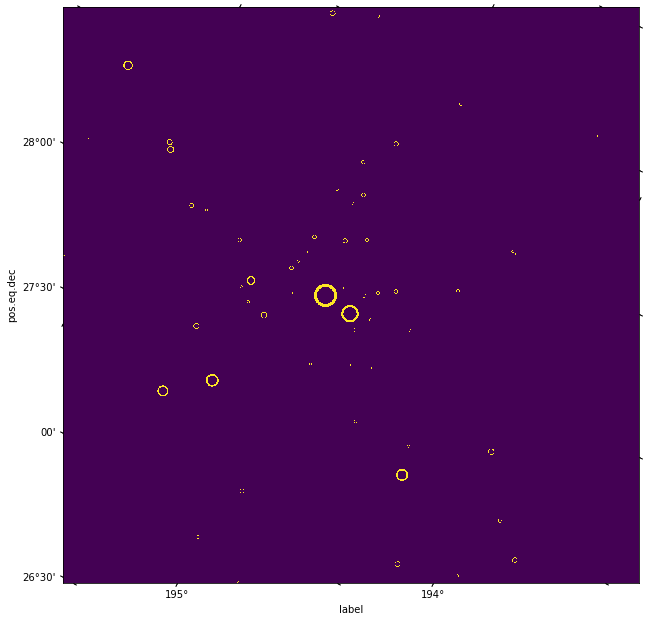

In [47]:
show_pic(np.flipud(np.rot90(exmpl[:,:,0])), projection=wcs)

In [54]:
pic = np.dstack(pic)
pic_n = np.copy(pic)
for i in range(6):
    pic_n[:,:,i] -= pic_n[:,:,i].min()
    pic_n[:,:,i] /= pic_n[:,:,i].max()

In [48]:
v = np.array([[[1], [2]],
              [[4], [5]]])
v[:,:,0]

array([[1, 2],
       [4, 5]])

In [49]:
b = np.array([[[0], [1]],
              [[1], [0]]])
b[:,:,0]

array([[0, 1],
       [1, 0]])

In [50]:
v[b] = 1

In [51]:
v[:,:,0]

array([[1, 1],
       [1, 1]])

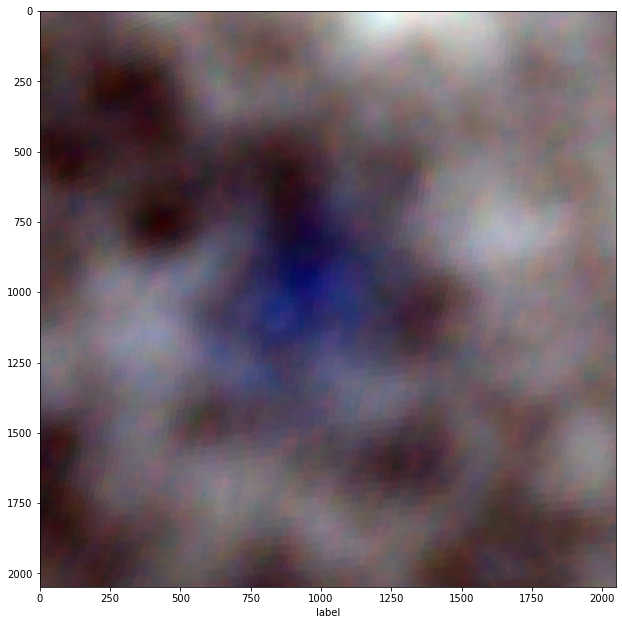

In [55]:
show_pic(pic_n[:,:,:3])

In [63]:
for i in range(6):
    pic_n[:,:,i] = np.maximum(pic_n[:,:,i], exmpl[:,:,0])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


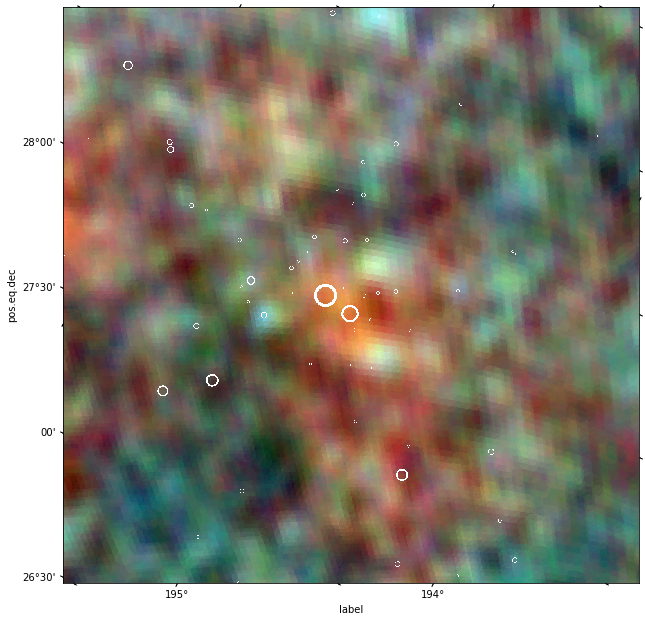

In [65]:
show_pic(np.flipud(np.rot90(pic_n[:,:,3:])), projection=wcs)

In [66]:
pic_n = np.flipud(np.rot90(pic_n))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


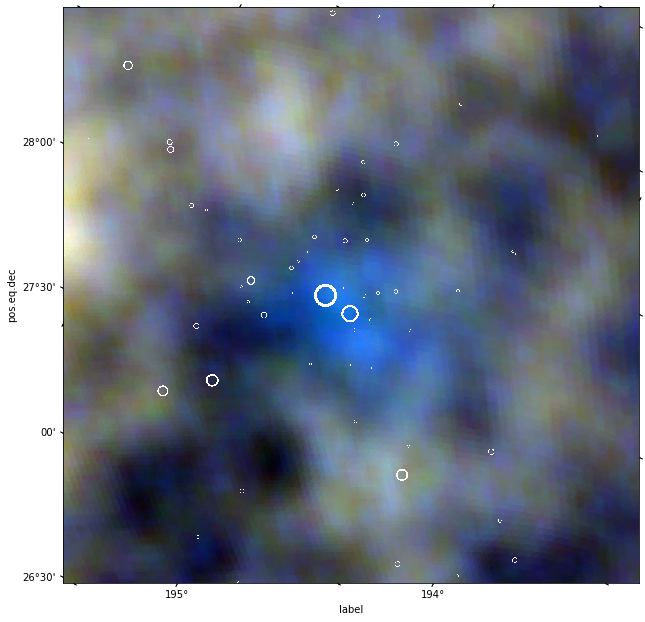

In [68]:
show_pic(pic_n[:,:,1:4], projection=wcs)

In [71]:
pic2fits(pic_n, wcs, '/home/rt2122/Data/Planck_normalized_DESI_LIS100.fits')

In [70]:
def pic2fits(pic, wcs, fitsname):
    from astropy.io import fits
    import numpy as np

    hdul = fits.HDUList([fits.PrimaryHDU(), 
        fits.ImageHDU(np.stack([pic[:,:,i] for i in range(pic.shape[-1])]), 
                     header=wcs.to_header())])

    hdul.writeto(fitsname)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


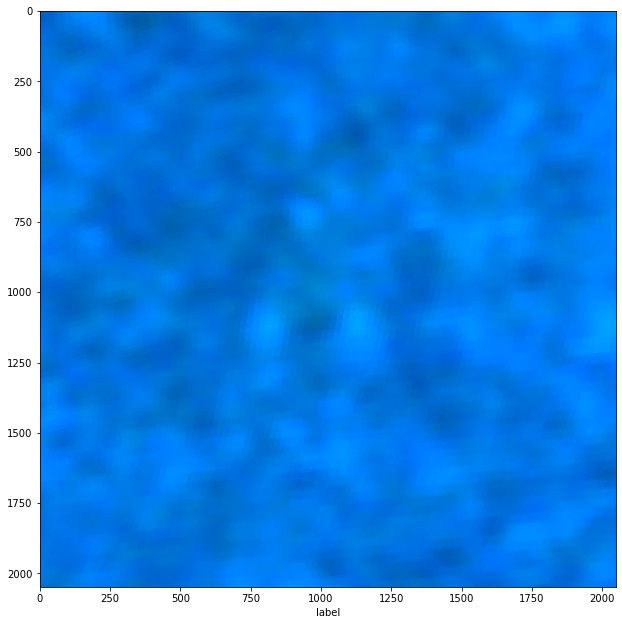

In [72]:
show_pic(pic[:,:,3:])

In [73]:
pic2fits(pic, wcs, '/home/rt2122/Data/Planck_original.fits')